In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
input_shape = (224,224,3)
image_size = (224, 224)
batch_size = 16

train_ds = keras.preprocessing.image_dataset_from_directory(
    directory = "D:/Projects/FINAL_Pruned_Dataset/FINAL_Pruned_Dataset/train/",
    validation_split=0.2,
    subset="training",
    seed=9,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = keras.preprocessing.image_dataset_from_directory(
    directory = "D:/Projects/FINAL_Pruned_Dataset/FINAL_Pruned_Dataset/train/",
    validation_split=0.2,
    subset="validation",
    seed=9,
    image_size=image_size,
    batch_size=batch_size,
)

test_ds = keras.preprocessing.image_dataset_from_directory(
    directory = "D:/Projects/FINAL_Pruned_Dataset/FINAL_Pruned_Dataset/test/",
    seed=9,
    image_size=image_size,
    batch_size=batch_size,
)

Found 8000 files belonging to 2 classes.
Using 6400 files for training.
Found 8000 files belonging to 2 classes.
Using 1600 files for validation.
Found 1174 files belonging to 2 classes.


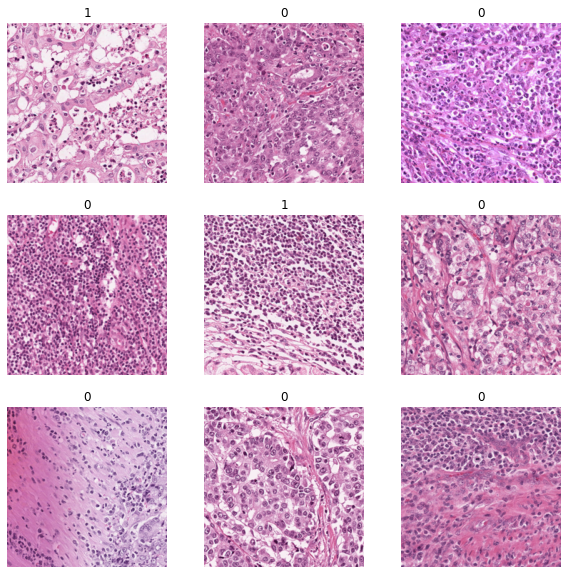

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [4]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
        #layers.experimental.preprocessing.RandomZoom(
           # height_factor = (0.2, 0.3),
           # width_factor=None,
           ## fill_mode='reflect', 
            #interpolation='bilinear'
           # )
    ]
)

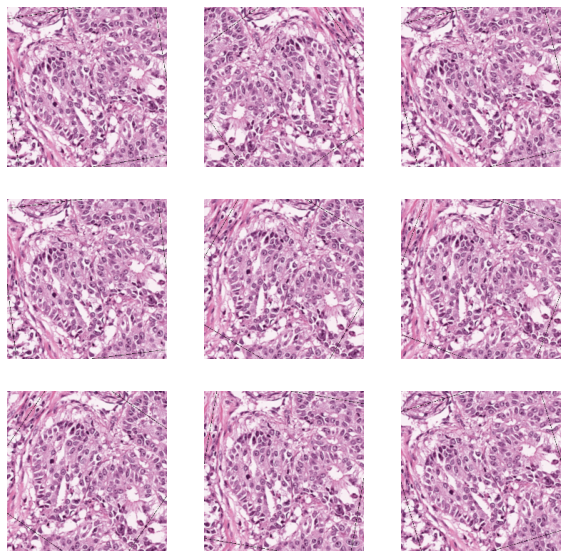

In [5]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [6]:
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.experimental.preprocessing.Rescaling(1./255)(x)
#...  # Rest of the model

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(512, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    x = layers.Conv2D(128, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.AveragePooling2D(pool_size=(2, 2))(x)
    
    x = layers.Conv2D(128, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.AveragePooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.AveragePooling2D(pool_size=(2, 2))(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [8]:
print(model.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 224, 224, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 224, 224, 3)  0           sequential[1][0]                 
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 512 14336       rescaling_1[0][0]                
_______________________________________________________________________________________

In [7]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger,ModelCheckpoint

In [9]:
filepath="D:/Updated-weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5" 

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath, monitor='val_loss', verbose=1, save_best_only=False,
    save_weights_only=False, mode='auto', save_freq='epoch', options=None
)

metrics = [
    tf.keras.metrics.TruePositives(name = 'tp'),
    tf.keras.metrics.FalsePositives(name = 'fp'),
    tf.keras.metrics.TrueNegatives(name = 'tn'),
    tf.keras.metrics.FalseNegatives(name = 'fn')
    tf.keras.metrics.BinaryAccuracy(name = 'accuracy'),
    tf.keras.metrics.Precision(name = 'precision'),
    tf.keras.metrics.Recall(name = 'recall'),
    tf.keras.metrics.AUC(name = 'auc')
]

#checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

log_csv = tf.keras.callbacks.CSVLogger('D:/my_logs.csv', separator=',', append=False)

earlystop = tf.keras.callbacks.EarlyStopping(patience=10)

learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.001, 
                                            min_lr=0.00001)

In [11]:
epochs = 30

callbacks = [checkpoint,  log_csv, earlystop, learning_rate_reduction]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=metrics)

history = model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds
                     
)


Epoch 1/30
400/400 [==============================] - ETA: 0s - loss: 0.6204 - accuracy: 0.6728
Epoch 00001: saving model to D:/Updated-weights-improvement-01-0.51.hdf5
400/400 [==============================] - 194s 485ms/step - loss: 0.6204 - accuracy: 0.6728 - val_loss: 0.7115 - val_accuracy: 0.5113
Epoch 2/30
400/400 [==============================] - ETA: 0s - loss: 0.5775 - accuracy: 0.7125
Epoch 00002: saving model to D:/Updated-weights-improvement-02-0.68.hdf5
400/400 [==============================] - 195s 488ms/step - loss: 0.5775 - accuracy: 0.7125 - val_loss: 0.6014 - val_accuracy: 0.6775
Epoch 3/30
400/400 [==============================] - ETA: 0s - loss: 0.5555 - accuracy: 0.7281
Epoch 00003: saving model to D:/Updated-weights-improvement-03-0.63.hdf5
400/400 [==============================] - 195s 489ms/step - loss: 0.5555 - accuracy: 0.7281 - val_loss: 0.7389 - val_accuracy: 0.6313
Epoch 4/30
400/400 [==============================] - ETA: 0s - loss: 0.5480 - accuracy:

Epoch 27/30
400/400 [==============================] - ETA: 0s - loss: 0.4409 - accuracy: 0.7945
Epoch 00027: saving model to D:/Updated-weights-improvement-27-0.76.hdf5
400/400 [==============================] - 202s 506ms/step - loss: 0.4409 - accuracy: 0.7945 - val_loss: 0.4966 - val_accuracy: 0.7556
Epoch 28/30
400/400 [==============================] - ETA: 0s - loss: 0.4356 - accuracy: 0.7962
Epoch 00028: saving model to D:/Updated-weights-improvement-28-0.76.hdf5
400/400 [==============================] - 204s 511ms/step - loss: 0.4356 - accuracy: 0.7962 - val_loss: 0.4841 - val_accuracy: 0.7613
Epoch 29/30
400/400 [==============================] - ETA: 0s - loss: 0.4380 - accuracy: 0.7995
Epoch 00029: saving model to D:/Updated-weights-improvement-29-0.76.hdf5
400/400 [==============================] - 203s 509ms/step - loss: 0.4380 - accuracy: 0.7995 - val_loss: 0.4988 - val_accuracy: 0.7556
Epoch 30/30
400/400 [==============================] - ETA: 0s - loss: 0.4477 - accur

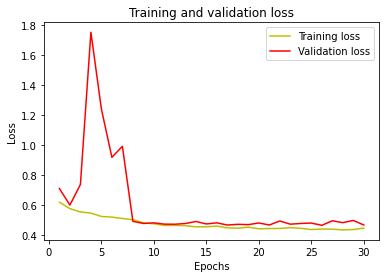

In [12]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

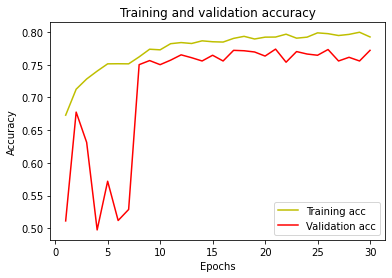

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [14]:
result = model.evaluate(test_ds)
print(result)

74/74 [==============================] - 12s 168ms/step - loss: 0.5454 - accuracy: 0.7419
[0.5454023480415344, 0.7419080138206482]


In [15]:
model.save("D:/73TestAccMod.h5")

In [17]:
from numpy import loadtxt
from keras.models import load_model
 

model = load_model('D:/Updated-weights-improvement-30-0.77.hdf5')
# summarize model.
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 224, 224, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 224, 224, 3)  0           sequential[0][0]                 
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 512 14336       rescaling_1[0][0]                
_______________________________________________________________________________________

In [18]:
score = model.evaluate(test_ds, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

74/74 [==============================] - 10s 138ms/step - loss: 0.5454 - accuracy: 0.7419
accuracy: 74.19%
